## Seminar 6

This seminar is based on https://github.com/yandexdataschool/nlp_course/tree/2019/week04_seq2seq

Today we compose the encoder-decoder neural networks and apply them to the task of machine translation.

![img](https://esciencegroup.files.wordpress.com/2016/03/seq2seq.jpg)
_(img: esciencegroup.files.wordpress.com)_


Encoder-decoder architectures are about converting anything to anything, including
 * Machine translation and spoken dialogue systems
 * [Image captioning](http://mscoco.org/dataset/#captions-challenge2015) and [image2latex](https://openai.com/requests-for-research/#im2latex) (convolutional encoder, recurrent decoder)
 * Generating [images by captions](https://arxiv.org/abs/1511.02793) (recurrent encoder, convolutional decoder)
 * Grapheme2phoneme - convert words to transcripts

## Our task: machine translation

We gonna try our encoder-decoder models on Russian to English machine translation problem. More specifically, we'll translate hotel and hostel descriptions. This task shows the scale of machine translation while not requiring you to train your model for weeks if you don't use GPU.

### Imports

Install an additional **subword-nmt** package

In [0]:
#if you run in collab, uncomment this
! pip install subword_nmt

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

import torch
import torch.nn as nn

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data and preprocessing

Before we get to the architecture, we do some preprocessing.

1) The data will be tokenized with __WordPunctTokenizer__.

2) Create a dictionary (remember the previous seminar about Language Modelling)

But dictionary of what?

Our data lines contain unique rare words. If we operate on a word-level, we will have to deal with large vocabulary size. If instead, we use character-level models, it would take lots of iterations to process a sequence. This time we're gonna pick something in between.
One popular approach is called Byte Pair Encoding aka BPE. The algorithm starts with character-level tokenization and then iteratively merges most frequent pairs for N iterations. This results in frequent words being merged into a single token and rare words split into syllables or even characters.

After preprocessing, we obtain files __\*.bpe.\*__ with tourists texts, splitting to BPE-tokens, and files of rules, which describes how every word in the vocabulary is split to tokens.



In [0]:
# uncomment this in collab
!wget https://www.dropbox.com/s/yy2zqh34dyhv07i/data.txt?dl=1 -O data.txt
!wget https://www.dropbox.com/s/fj9w01embfxvtw1/dummy_checkpoint.npz?dl=1 -O dummy_checkpoint.npz
!wget --no-check-certificate -r 'https://docs.google.com/uc?export=download&id=1op5MWlEiroEAXxsMR6AUkdNuG634JzYc' -O utils.py


--2019-12-04 16:50:11--  https://www.dropbox.com/s/yy2zqh34dyhv07i/data.txt?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/yy2zqh34dyhv07i/data.txt [following]
--2019-12-04 16:50:11--  https://www.dropbox.com/s/dl/yy2zqh34dyhv07i/data.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucf8492952df9c9fc7b940b06a07.dl.dropboxusercontent.com/cd/0/get/AtnacyBjj1ldqMRGLWMPH82HXa4oTsdTps6FydbZ2T7xVYpanPYk8EwCpAX_BYwRrz92IcRVVypQqAKfWgeTf5e8_Upja8SqONLFIKKh0TXUXw/file?dl=1# [following]
--2019-12-04 16:50:11--  https://ucf8492952df9c9fc7b940b06a07.dl.dropboxusercontent.com/cd/0/get/AtnacyBjj1ldqMRGLWMPH82HXa4oTsdTps6FydbZ2T7xVYpanPYk8EwCpAX_BYwRrz92IcRVVypQqAKfWgeTf5e8_Upja8SqONLFIKKh0TXUXw/file?dl=1
Resolving ucf8492952d

In [0]:
tokenizer = WordPunctTokenizer()
def tokenize(x):
    return ' '.join(tokenizer.tokenize(x.lower()))

# split and tokenize the data
with open('train.en', 'w') as f_src,  open('train.ru', 'w') as f_dst:
    for line in open('data.txt'):
        src_line, dst_line = line.strip().split('\t')
        f_src.write(tokenize(src_line) + '\n')
        f_dst.write(tokenize(dst_line) + '\n')

# build and apply bpe vocs
bpe = {}
for lang in ['en', 'ru']:
    learn_bpe(open('./train.' + lang), open('bpe_rules.' + lang, 'w'), num_symbols=8000)
    bpe[lang] = BPE(open('./bpe_rules.' + lang))
    
    with open('train.bpe.' + lang, 'w') as f_out:
        for line in open('train.' + lang):
            f_out.write(bpe[lang].process_line(line.strip()) + '\n')

In [0]:
!head train.bpe.en | tee head.txt

cor@@ del@@ ia hotel is situated in tbilisi , a 3 - minute walk away from saint trinity church .
at tu@@ pi@@ r@@ mar@@ ka lodge you will find a 24 - hour front desk , room service , and a snack bar .
featuring free wifi in all areas , nai@@ g@@ ao xiao@@ wo offers accommodation in shanghai .
each has a tv and a private bathroom with shower .
your room comes with air conditioning and satellite tv .
they are styled in cream - coloured hu@@ es and some of them feature private balconies with seating areas .
the reception team can help guests plan sightseeing trips .
some units include a seating area for your convenience .
ni@@ eu@@ w@@ markt as well as kal@@ ver@@ straat , hermitage and rem@@ brand@@ t@@ plein are within 15 minutes walking .
the danube delta is a natural reserve where you can go fishing , bird watching , take boat rides or simply unwind surrounded by nature .


### Split to train-dev
..and look at examples of data in train and dev

In [0]:
data_inp = np.array(open('./train.bpe.ru').read().split('\n'))
data_out = np.array(open('./train.bpe.en').read().split('\n'))

from sklearn.model_selection import train_test_split
train_inp, dev_inp, train_out, dev_out = train_test_split(data_inp, data_out, test_size=3000,
                                                          random_state=42)
for i in range(3):
    print('inp:', train_inp[i])
    print('out:', train_out[i], end='\n\n')

inp: на территории обустроена бесплатная частная парковка .
out: free private parking is available on site .

inp: кроме того , в 5 минутах ходьбы работают многочисленные бары и рестораны .
out: guests can find many bars and restaurants within a 5 - minute walk .

inp: отель san mi@@ gu@@ el расположен в центре мор@@ ели@@ и , в 750 метрах от главной площади города и кафедрального собора .
out: hotel san miguel is located in central more@@ lia , 750 metres from the city ’ s main square and cathedral .



### Building vocabularies

In seminar 4 we build a vocabulary over tokens. 

On vocabulary base (**ids_to_token, token_to_ids**) we provide **to_matrix** function. Now this function and vocab class are in **util.py**. Besides **to_matrix** we provide **matrix_to_line**, which corresponds matrix of token indices to real line. 



__Vocab__ class and and its functionality works like this:

In [0]:
from utils import Vocab

inp_voc = Vocab.from_lines(train_inp)
out_voc = Vocab.from_lines(train_out)

Here's how you cast lines into ids and backwards.

In [0]:
batch_lines = sorted(train_inp, key=len)[5:10]
batch_ids = inp_voc.to_matrix(batch_lines)
batch_lines_restored = inp_voc.to_lines(batch_ids)

print("lines")
print(batch_lines)
print("\nwords to ids (0 = bos, 1 = eos):")
print(batch_ids)
print("\nback to words")
print(batch_lines_restored)

lines
['гостевой дом r .', 'до афин — 20 км .', 'работает боулинг .', 'оборудован балкон .', 'подключен wi - fi .']

words to ids (0 = bos, 1 = eos):
[[   0 2688 2943 1108   29    1    1    1]
 [   0 2922 1834 8035   59 3800   29    1]
 [   0 6030 2083   29    1    1    1    1]
 [   0 4927 1870   29    1    1    1    1]
 [   0 5549 1453   27  592   29    1    1]]

back to words
['гостевой дом r .', 'до афин — 20 км .', 'работает боулинг .', 'оборудован балкон .', 'подключен wi - fi .']


We also define functions to compute lengths of every line in batch and create a mask for inference based on it (as in __seminar4__)

In [0]:
def sequence_mask(lengths, maxlen, dtype=torch.bool):
    """
    :param lenghts: array of size K, lenghts of input K lines
    :param maxlen: number of steps in our case
    """
    if maxlen is None:
        maxlen = lengths.max()
    cuda_check = lengths.is_cuda
    if cuda_check:
        cuda_device = lengths.get_device()
    
    one_tensor = torch.ones((len(lengths), maxlen))
    if (cuda_check):
        one_tensor = one_tensor.cuda(device=cuda_device)
    
    mask = ~(one_tensor.cumsum(dim=1).t() > lengths).t()
    mask.type(dtype)
    return mask

def infer_length(input_ix, eos_ix, time_major=False):
    """ compute length of each line in input ix (incl. first EOS), int32 vector of shape [batch_size] """
    """ Cont number of non-zero indexes """
    axis = 0 if time_major else 1
    a = input_ix.eq(eos_ix)
    count_eos = torch.cumsum(a, axis)
    lengths = torch.sum(count_eos.eq(0), axis)
    return lengths + 1 

def infer_mask(seq, eos_ix, time_major=False):
    """
    compute mask given output indices and eos code
    :param seq: tf matrix [time,batch] if time_major else [batch,time]
    :param eos_ix: integer index of end-of-sentence token
    :returns: mask, float32 matrix with '0's and '1's of same shape as seq
    """
    axis = 0 if time_major else 1
    lengths = infer_length(seq, eos_ix, time_major=time_major)
    mask = sequence_mask(lengths, maxlen=seq.size()[axis])
    if time_major: mask = mask.transpose(1, 0)
    return mask


### Simple encoder-decoder model

* The picture below contains a scheme for a simple encoder-decoder model: single GRU encoder/decoder, no attention or anything.

* The chain between encoder and decoder: In the simplest seq2seq decoder we use only last output of the encoder. This last output is sometimes called the context vector as it encodes context from the entire sequence. This context vector is used as the initial hidden state of the decoder.



![img](https://docs.google.com/uc?export=download&id=1srrm_If8MMWVoUl-qEJ1ieteC5dAwvhm)

* TRAIN MODE

When we train model and target lines are known, __out[i]__ is a i-th token from the corresponding target line.
It is function __decode()__ in the model below.

* GENERATE MODE

__out[i]__ is a previously generated token, obtain from previous logits (by __argmax__, for example) 
It is function __decode_inference()__

The picture describes **TRAIN_MODE**


In [0]:
class BasicModel(nn.Module):
    def __init__(self, inp_voc, out_voc, device, emb_size=64, hid_size=128):
        """
        A simple encoder-decoder model
        """
        super().__init__() 
        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size

        # your code here
        
        self.device = device
        
    def initHidden(self, batch_size):
        return torch.zeros(1, batch_size, self.hid_size)

    def encode(self, inp, **flags):
        """
        Takes symbolic input sequence, computes initial state
        :param inp: matrix of input tokens [batch, time]
        :returns: initial decoder state tensors, one or many
        """
        
        # your code here
        
        return output, hidden


    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Takes previous decoder state and tokens, returns new state and logits for next tokens
        :param prev_state: a list of previous decoder state tensors
        :param prev_tokens: previous output tokens, an int vector of [batch_size]
        :return: a list of next decoder state tensors, a tensor of logits [batch, n_tokens]
        """

        prev_tokens = torch.unsqueeze(prev_tokens, 1)
        
        # your code here
        
        return new_dec_state, output_logits

    def decode(self, initial_state, out_tokens, **flags):
        """ Run decoder on reference tokens (out_tokens) """
        """ TRAIN MODE """
        state = initial_state
        batch_size = out_tokens.shape[0]

        # initial logits: always predict BOS
        first_logits = torch.ones((batch_size, 1), dtype=torch.long).fill_(self.out_voc.bos_ix)

        first_logits_onehot = torch.Tensor(batch_size, len(self.out_voc)).zero_()

        first_logits_onehot.scatter_(1, first_logits, 1)
        
        first_logits = torch.log(first_logits_onehot + 1e-30).to(device)

        outputs = [torch.unsqueeze(first_logits, 1)]
        for i in range(out_tokens.shape[1] - 1):
            # your code here
            outputs.append(logits)
        return torch.cat(outputs, 1)

    def forward(self, inp, out):
        """ Apply model in training mode """
        encoder_output, encoder_hidden = self.encode(inp)
        
        return self.decode(encoder_hidden, out)

    def decode_inference(self, initial_state, max_len=100, **flags):
        """ Generate translations from model (greedy version) """
        """ GENERATE MODE """
        state = initial_state
        prev_elems = torch.ones(initial_state[0].shape[0]).to(self.device).to(torch.int64) * self.out_voc.bos_ix
        outputs = [prev_elems.unsqueeze(1)]
        all_states = [initial_state]
        for i in range(max_len):
            # your code here
            all_states.append(state)
        return torch.cat(outputs, 1), all_states

    def translate_lines(self, inp_lines):
        encoder_output, encoder_hidden = self.encode(inp_lines)
        out_ids, states = self.decode_inference(encoder_hidden)
        return out_voc.to_lines(out_ids.cpu().detach().numpy()), states


Test model creation and logits prediction:

In [0]:
device = torch.device("cpu" if torch.cuda.is_available() else "cpu") 
model = BasicModel(inp_voc, out_voc, device)
model.to(device)

BasicModel(
  (emb_inp): Embedding(8048, 64)
  (emb_out): Embedding(7801, 64)
  (enc0): GRU(64, 128, batch_first=True)
  (dec0): GRU(64, 128, batch_first=True)
  (dec_dense): Linear(in_features=128, out_features=7801, bias=True)
  (logits): LogSoftmax()
)

In [0]:
dummy_inp = torch.tensor(inp_voc.to_matrix(train_inp[:3])).to(torch.int64)
dummy_out = torch.tensor(out_voc.to_matrix(train_out[:3])).to(torch.int64)
dummy_logits = model(dummy_inp.to(device), dummy_out.to(device))
ref_shape = (dummy_out.shape[0], dummy_out.shape[1], len(out_voc))
assert dummy_logits.shape == ref_shape, "Your logits shape should be {} but got {}".format(dummy_logits.shape, ref_shape)
assert all(dummy_logits[:, 0].cpu().detach().numpy().argmax(-1) == out_voc.bos_ix), "first step must always be BOS"

In [0]:
dummy_inp.shape

torch.Size([3, 25])

### Training loss

Our training objetive is almost the same as it was for neural language models:
$$ L = {\frac1{|D|}} \sum_{X, Y \in D} \sum_{y_t \in Y} - \log p(y_t \mid y_1, \dots, y_{t-1}, X, \theta) $$

where $|D|$ is the __total length of all sequences__, including BOS and first EOS, but excluding PAD.

This loss is similar to ones in 4th seminar, but:

* instead of sum up over the sequence and than average between all lines in batch we __sum up token losses__ (excluding PAD tokens!) in all batch and __divide it to number of non-pad tokens__

In [0]:
def compute_loss(model, inp, out, **flags):
    """
    Compute loss (float32 scalar) as in the formula above
    :param inp: input tokens matrix, int32[batch, time]
    :param out: reference tokens matrix, int32[batch, time]
    
    In order to pass the tests, your function should
    * include loss at first EOS but not the subsequent ones
    * divide sum of losses by a sum of input lengths (use infer_length or infer_mask)
    """
    
    
    # your code here
    
    return   # scalar

In [0]:
dummy_loss = compute_loss(model, dummy_inp.to(device), dummy_out.to(device))
print("Loss:", dummy_loss)
assert np.allclose(dummy_loss.cpu().detach().numpy(), 8.425, rtol=0.1, atol=0.1), "We're sorry for your loss"

Loss: tensor(8.4400, grad_fn=<DivBackward0>)


### Evaluation: BLEU

Machine translation is commonly evaluated with [BLEU](https://en.wikipedia.org/wiki/BLEU) score. This metric simply computes which fraction of predicted n-grams is actually present in the reference translation. It does so for n=1,2,3 and 4 and computes the geometric average with penalty if translation is shorter than reference.

While BLEU [has many drawbacks](http://www.cs.jhu.edu/~ccb/publications/re-evaluating-the-role-of-bleu-in-mt-research.pdf), it still remains the most commonly used metric and one of the simplest to compute.

In [0]:
from nltk.translate.bleu_score import corpus_bleu
def compute_bleu(model, inp_lines, out_lines, bpe_sep='@@ ', **flags):
    """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
    dev_inp_tensor = torch.tensor(inp_voc.to_matrix(inp_lines)).to(torch.int64).to(device)
    # your code here
    del dev_inp_tensor
    # Note: if you experience out-of-memory error, split input lines into batches and translate separately
    return corpus_bleu(
        # your code here)
        
## HINT: smoothing_function=lambda precisions, **kw: [p + 1.0 / p.denominator for p in precisions]) * 100

In [0]:
compute_bleu(model, dev_inp, dev_out)

(3000,)


0.0018273646763056592

### Training parameters

Training encoder-decoder models isn't that different from any other models: sample batches, compute loss, backprop and update

Set optimizer, batch_size, vocabulary for loss and metrics for visualization.

In [0]:
from IPython.display import clear_output
from tqdm import tqdm, trange
metrics = {'train_loss': [], 'dev_bleu': [] }

optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
batch_size = 32

In [0]:
print("Loss:", dummy_loss.cpu().detach().item())

Loss: 8.417143821716309


In [0]:
metrics['dev_bleu'].append(compute_bleu(model, dev_inp, dev_out))

(3000,)


## Training 
To achieve reasonable results, it is enough to do 5000 iterations

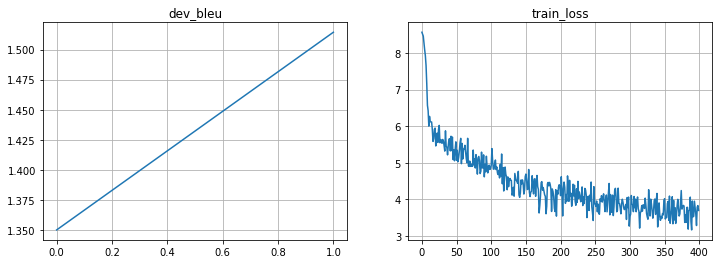

Mean loss=3.694


  2%|▏         | 400/25000 [07:36<59:50:03,  8.76s/it]

3.9790327548980713


  2%|▏         | 401/25000 [07:38<44:20:30,  6.49s/it]

3.33984375


  2%|▏         | 402/25000 [07:39<33:02:00,  4.83s/it]

3.2815730571746826


  2%|▏         | 403/25000 [07:40<25:14:58,  3.70s/it]

3.466057777404785


  2%|▏         | 404/25000 [07:41<19:42:33,  2.88s/it]

3.93691349029541


  2%|▏         | 405/25000 [07:41<15:18:48,  2.24s/it]

3.3605897426605225


  2%|▏         | 406/25000 [07:42<12:37:50,  1.85s/it]

KeyboardInterrupt: ignored

In [0]:
metrics = {'train_loss': [], 'dev_bleu': [] }

optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
batch_size = 32


for _ in trange(25000):
    step = len(metrics['train_loss']) + 1
    batch_ix = np.random.randint(len(train_inp), size=batch_size)
    batch_inp = torch.tensor(inp_voc.to_matrix(train_inp[batch_ix])).to(torch.int64).to(device)
    batch_out = torch.tensor(out_voc.to_matrix(train_out[batch_ix])).to(torch.int64).to(device)
    optimizer.zero_grad()
    loss_i = compute_loss(model, batch_inp, batch_out)
    print(loss_i.cpu().detach().item())
    metrics['train_loss'].append(loss_i.cpu().detach().item())
    
    if step % 200 == 0:
        metrics['dev_bleu'].append(compute_bleu(model, dev_inp, dev_out))
        
        clear_output(True)
        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(history)
            plt.grid()
        plt.show()
        print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0), flush=True)
        
    loss_i.backward()
    optimizer.step()

    
        
# Note: it's okay if bleu oscillates up and down as long as it gets better on average over long term (e.g. 5k batches)

In [0]:
np.mean(metrics['train_loss'][-10:], axis=0)

3.5971691608428955

In [0]:
np.mean(metrics['dev_bleu'][-10:], axis=0)

1.4321797708537967

**Look at the translation.**
**Not bad, but not brilliant**

In [0]:
dev_inp_tensor = torch.tensor(inp_voc.to_matrix(dev_inp[::500])).to(torch.int64).to(device)
for inp_line, trans_line in zip(dev_inp[::500], model.translate_lines(dev_inp_tensor)[0]):
    print(inp_line)
    print(trans_line)
    print()

в распоряжении гостей общая кухня и общая гостиная .
the property offers free parking .

кроме того , предоставляется прокат велосипедов , услуги трансфера и бесплатная парковка .
the property offers free parking .

расстояние до города ки@@ сси@@ м@@ ми составляет 26 км .
the nearest airport is a 15 - minute drive away .

апартаменты в пент@@ хаусе с общим открытым бассейном , садом , кондиционером и террасой для загара расположены в 5 минутах ходьбы от пляжа на курорте ка@@ бо - рой .
the property is a 5 - minute walk from the beach , while the nearest airport is located in the property .

апартаменты mo@@ s@@ co@@ w point - loft red square находятся в москве , в 200 метрах от большого театра .
the nearest airport is located in the property .

в вашем распоряжении собственная ванная комната с душем и полотенцами .
the property has a shower .



# Attention ... is all you need

In [1]:
from IPython.display import Image
Image(url='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/attention_mechanism.gif')  

### Your Attention Required

In this section we want you to improve over the basic model by implementing a simple attention mechanism.

This is gonna be a two-parter: building the __attention layer__ and using it for an __attentive seq2seq model__.

### Attention layer

Here you will have to implement a layer that computes a simple additive attention:

Given encoder sequence $ h^e_0, h^e_1, h^e_2, ..., h^e_T$ and a single decoder state $h^d$,

* Compute logits with a 2-layer neural network
$$a_t = linear_{out}(tanh(linear_{e}(h^e_t) + linear_{d}(h_d)))$$
* Get probabilities from logits, 
$$ p_t = {{e ^ {a_t}} \over { \sum_\tau e^{a_\tau} }} $$

* Add up encoder states with probabilities to get __attention response__
$$ attn = \sum_t p_t \cdot h^e_t $$

You can learn more about attention layers in the leсture slides or [from this post] (https://distill.pub/2016/augmented-rnns/) or from [here],(https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html)

class __AttentionLayer__ works in __decode_step__ in common model.

* Input parameters:

  __enc_size__, __dec_size__ - size of hidden states from encoder and decoder respectively. Not equal in common case
  
  __hid_size__ - size of a_t 
  
  __enc__ - all sequence of **hidden_states** from encoder, bs * seq_len * enc_size
  
  __dec__ -  **hidden_state** from decoder, bs * dec_size
  
* Input parameters:

    __probas__ - weighst of every encoder state consider the decoder, *p_t*
    
    __attn__ - the weighted sum of encoder states, *attn*


In [0]:
class AttentionLayer(nn.Module):
    def __init__(self, name, enc_size, dec_size, hid_size):
        """ A layer that computes additive attention response and weights """
        super().__init__()
        
        self.enc_size = enc_size 
        self.dec_size = dec_size 
        self.hid_size = hid_size 
        self.activ = nn.Tanh()  

        self.linear_enc = #your code here
        self.linear_dec = #your code here
        self.linear_out = #your code here
        
        self.softmax = nn.Softmax(dim = 1)

    def forward(self, enc, dec, inp_mask):
        """
        Computes attention response and weights
        :param enc: encoder activation sequence, float32[batch_size, ninp, enc_size]
        :param dec: single decoder state used as "query", float32[batch_size, dec_size]
        :param inp_mask: mask on enc activatons (0 after first eos), float32 [batch_size, ninp]
        :returns: attn[batch_size, enc_size], probs[batch_size, ninp]
            - attn - attention response vector (weighted sum of enc)
            - probs - attention weights after softmax
        """
        
        
        # Compute logits
        
        # your code here
        
        # Apply mask - if mask is 0, logits should be -inf or -1e9
        
        # your code here
        
        # Compute attention probabilities (softmax)
        
        # your code here
        
        # Compute attention response using enc and probs
        

        return attn, probs

In [0]:
m = AttentionLayer("my_sweet_attn", 128, 128, 128)

### Seq2seq model with attention

You can now use the attention layer to build a network. The simplest way to implement attention is to use it in decoder phase:
![img](https://i.imgur.com/6fKHlHb.png)
_image from distill.pub [article](https://distill.pub/2016/augmented-rnns/)_

On every step, use __previous__ decoder state to obtain attention response. Then feed concat this response to the inputs of next attetion layer.

The key implementation detail here is __model state__. Put simply, you can add any tensor into the list of `encode` outputs. You will then have access to them at each `decode` step. This may include:
* Last RNN hidden states (as in basic model)
* The whole sequence of encoder outputs (to attend to) and mask
* Attention probabilities (to visualize)

_There are, of course, alternative ways to wire attention into your network and different kinds of attention. Take a look at [this](https://arxiv.org/abs/1609.08144), [this](https://arxiv.org/abs/1706.03762) and [this](https://arxiv.org/abs/1808.03867) for ideas. And for image captioning/im2latex there's [visual attention](https://arxiv.org/abs/1502.03044)_

In [0]:
class AttentiveModelLayer(BasicModel):
    def __init__(self, inp_voc, out_voc, device, emb_size=64, hid_size=128, attn_size = 128):
        """
        A simple encoder-decoder model
        """
        super().__init__(inp_voc, out_voc, device) # initialize base class to track sub-layers, trainable variables, etc.
        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size

        # your code here
        
        self.device = device
        
        self.l_attention = AttentionLayer("Attention", hid_size, hid_size, attn_size)

    def encode(self, inp, **flags):
        """
        Takes symbolic input sequence, computes initial state
        :param inp: matrix of input tokens [batch, time]
        :returns: initial decoder state tensors, one or many
        """
        # your code here
        return output, hidden, embedded, mask


    def decode_step(self, prev_state, encoder_sequence, mask, prev_tokens, **flags):
        """
        Takes previous decoder state and tokens, returns new state and logits for next tokens
        :param prev_state: a list of previous decoder state tensors
        :param prev_tokens: previous output tokens, an int vector of [batch_size]
        :return: a list of next decoder state tensors, a tensor of logits [batch, n_tokens]
        """

        # your code here
        
        return new_dec_state, output_logits, t_probs

    def decode(self, initial_state, out_tokens, **flags):
        """ Run decoder on reference tokens (out_tokens) """
        """ TRAIN MODE """
        encoder_sequence, state, encoder_emb, mask = initial_state
        batch_size = out_tokens.shape[0]

        # initial logits: always predict BOS
        first_logits = torch.ones((batch_size, 1), dtype=torch.long).fill_(self.out_voc.bos_ix)

        first_logits_onehot = torch.Tensor(batch_size, len(self.out_voc)).zero_()

        first_logits_onehot.scatter_(1, first_logits, 1)
        
        first_logits = torch.log(first_logits_onehot + 1e-30).to(device)

        outputs = [torch.unsqueeze(first_logits, 1)]
        aprobs = [torch.zeros(mask.shape)]
        for i in range(out_tokens.shape[1] - 1):
            # your code here
            outputs.append(logits)
            aprobs.append(aprob)
        return torch.cat(outputs, 1)

    def forward(self, inp, out):
        """ Apply model in training mode """
        encoder_output, encoder_hidden, embedded, mask = self.encode(inp)
        
        return self.decode((encoder_output, encoder_hidden, embedded, mask), out)

    def decode_inference(self, initial_state, max_len=100, **flags):
        """ Generate translations from model (greedy version) """
        """ GENERATE MODE """
        encoder_sequence, state, encoder_emb, mask = initial_state
        prev_elems = torch.ones(initial_state[0].shape[0]).to(self.device).to(torch.int64) * self.out_voc.bos_ix
        outputs = [prev_elems.unsqueeze(1)]
        all_states = [initial_state]
        aprobs = [torch.zeros(mask.shape)]
        for i in range(max_len):
            # your code here
            outputs.append(torch.argmax(logits, axis=-1))
            all_states.append(state)
            aprobs.append(aprob)
        return torch.cat(outputs, 1), all_states, aprobs

    def translate_lines(self, inp_lines):
        encoder_information = self.encode(inp_lines)
        out_ids, states, aprobs = self.decode_inference(encoder_information)
        return out_voc.to_lines(out_ids.cpu().detach().numpy()), states, aprobs

In [0]:
device = torch.device("cpu" if torch.cuda.is_available() else "cpu") 
model = AttentiveModelLayer(inp_voc, out_voc, device)
model.to(device)
dummy_inp = torch.tensor(inp_voc.to_matrix(train_inp[:3])).to(torch.int64)
dummy_out = torch.tensor(out_voc.to_matrix(train_out[:3])).to(torch.int64)
dummy_logits = model(dummy_inp.to(device), dummy_out.to(device))

In [0]:
dummy_loss = compute_loss(model, dummy_inp, dummy_out)
print("Loss:", dummy_loss)

Loss: tensor(8.4232, grad_fn=<DivBackward0>)


In [0]:
compute_bleu(model, dev_inp, dev_out)

KeyboardInterrupt: ignored

### Training attentive model

Please reuse the infrastructure you've built for the regular model. I hope you didn't hard-code anything :)

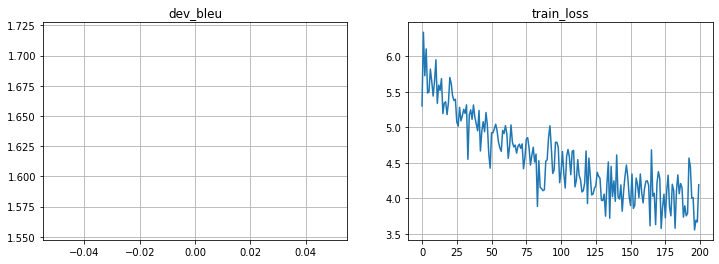

Mean loss=3.969





  1%|          | 200/25000 [04:36<106:46:31, 15.50s/it]

3.8324215412139893





  1%|          | 201/25000 [04:37<76:56:07, 11.17s/it] 

3.734429359436035





  1%|          | 202/25000 [04:38<56:04:59,  8.14s/it]

3.998544216156006





  1%|          | 203/25000 [04:40<42:05:51,  6.11s/it]

4.281213760375977





  1%|          | 204/25000 [04:41<31:56:17,  4.64s/it]

4.00761604309082





  1%|          | 205/25000 [04:42<24:57:02,  3.62s/it]

4.3542680740356445





  1%|          | 206/25000 [04:44<20:25:16,  2.97s/it]

4.19662618637085





  1%|          | 207/25000 [04:45<16:01:43,  2.33s/it]

3.584852695465088





  1%|          | 208/25000 [04:45<13:02:33,  1.89s/it]

4.142045021057129





  1%|          | 209/25000 [04:47<11:59:38,  1.74s/it]

3.9993388652801514





  1%|          | 210/25000 [04:48<10:59:23,  1.60s/it]

3.6892364025115967





  1%|          | 211/25000 [04:49<9:27:09,  1.37s/it] 

3.9879612922668457





  1%|          | 212/25000 [04:50<8:59:15,  1.31s/it]

3.668619394302368





  1%|          | 213/25000 [04:51<8:14:06,  1.20s/it]

4.037206172943115





  1%|          | 214/25000 [04:52<7:51:14,  1.14s/it]

3.8864471912384033





  1%|          | 215/25000 [04:53<8:11:56,  1.19s/it]

4.026228427886963





  1%|          | 216/25000 [04:54<7:39:14,  1.11s/it]

3.8626279830932617





  1%|          | 217/25000 [04:56<8:01:16,  1.17s/it]

3.839902400970459





  1%|          | 218/25000 [04:56<7:34:28,  1.10s/it]

4.006775856018066





  1%|          | 219/25000 [04:58<7:27:33,  1.08s/it]

3.8136446475982666





  1%|          | 220/25000 [04:59<7:22:37,  1.07s/it]

4.2519097328186035





  1%|          | 221/25000 [05:00<7:33:50,  1.10s/it]

3.6178998947143555





  1%|          | 222/25000 [05:01<7:37:11,  1.11s/it]

3.891502857208252





  1%|          | 223/25000 [05:02<7:28:59,  1.09s/it]

3.9915871620178223





  1%|          | 224/25000 [05:03<7:29:42,  1.09s/it]

4.106388568878174





  1%|          | 225/25000 [05:04<7:51:12,  1.14s/it]

3.760352373123169





  1%|          | 226/25000 [05:05<7:09:55,  1.04s/it]

3.6772971153259277





  1%|          | 227/25000 [05:06<7:30:33,  1.09s/it]

4.447758197784424





  1%|          | 228/25000 [05:08<7:51:38,  1.14s/it]

4.00049352645874





  1%|          | 229/25000 [05:08<7:27:34,  1.08s/it]

3.78666353225708





  1%|          | 230/25000 [05:10<7:40:40,  1.12s/it]

3.6633687019348145





  1%|          | 231/25000 [05:11<7:41:50,  1.12s/it]

3.858546495437622





  1%|          | 232/25000 [05:12<7:39:33,  1.11s/it]

3.5678582191467285





  1%|          | 233/25000 [05:13<8:14:13,  1.20s/it]

3.2826690673828125





  1%|          | 234/25000 [05:14<8:09:15,  1.19s/it]

3.8461251258850098





  1%|          | 235/25000 [05:16<8:23:15,  1.22s/it]

3.5186288356781006





  1%|          | 236/25000 [05:17<8:00:56,  1.17s/it]

4.032811641693115





  1%|          | 237/25000 [05:18<8:01:29,  1.17s/it]

3.1587257385253906





  1%|          | 238/25000 [05:19<8:29:40,  1.23s/it]

3.380850315093994





  1%|          | 239/25000 [05:20<7:57:35,  1.16s/it]

3.9161601066589355





  1%|          | 240/25000 [05:22<8:04:16,  1.17s/it]

3.720252275466919





  1%|          | 241/25000 [05:23<7:57:30,  1.16s/it]

3.6421923637390137





  1%|          | 242/25000 [05:24<7:52:43,  1.15s/it]

3.6440112590789795





  1%|          | 243/25000 [05:25<8:11:48,  1.19s/it]

3.581847667694092





  1%|          | 244/25000 [05:26<7:40:09,  1.12s/it]

3.4561917781829834





  1%|          | 245/25000 [05:27<7:33:57,  1.10s/it]

3.8947956562042236





  1%|          | 246/25000 [05:28<7:26:12,  1.08s/it]

3.8134548664093018





  1%|          | 247/25000 [05:29<7:49:52,  1.14s/it]

3.4619171619415283





  1%|          | 248/25000 [05:31<7:49:26,  1.14s/it]

3.407609224319458





  1%|          | 249/25000 [05:31<7:23:45,  1.08s/it]

3.9134483337402344


In [0]:
metrics = {'train_loss': [], 'dev_bleu': [] }

optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
batch_size = 32


for _ in trange(25000):
    step = len(metrics['train_loss']) + 1
    batch_ix = np.random.randint(len(train_inp), size=batch_size)
    batch_inp = torch.tensor(inp_voc.to_matrix(train_inp[batch_ix])).to(torch.int64).to(device)
    batch_out = torch.tensor(out_voc.to_matrix(train_out[batch_ix])).to(torch.int64).to(device)
    optimizer.zero_grad()
    loss_i = compute_loss(model, batch_inp, batch_out)
    print(loss_i.cpu().detach().item())
    metrics['train_loss'].append(loss_i.cpu().detach().item())
    
    if step % 200 == 0:
        metrics['dev_bleu'].append(compute_bleu(model, dev_inp, dev_out))
        
        clear_output(True)
        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(history)
            plt.grid()
        plt.show()
        print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0), flush=True)
        
    loss_i.backward()
    optimizer.step()


In [0]:
dev_inp_tensor = torch.tensor(inp_voc.to_matrix(dev_inp[::500])).to(torch.int64).to(device)
for inp_line, trans_line in zip(dev_inp[::500], model.translate_lines(dev_inp_tensor)[0]):
    print(inp_line)
    print(trans_line)
    print()